# Benchmarks

Compare paper results with Keras network to Pytorch networks. Adapted from 5_Diagnostic notebook from paper. 

In [1]:
import sys
import os

import itertools
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Inspector:
    def __init__(self):
        pass

    def loadPnl(self, path, measure, op_type=None):
        df = pd.read_csv(path, index_col=0)


        bl = self.choose_op_type(df, op_type)

        if measure == 'mse':
            return (df.loc[bl, 'PNL']**2).mean()
        elif measure == 'mean':
            return (df.loc[bl, 'PNL']).mean()
        elif measure == 'median':
            return (df.loc[bl, 'PNL']).median()
        elif measure == 'lower5%VaR':
            return (df.loc[bl, 'PNL']).quantile(0.05)
        elif measure == 'upper95%VaR':
            return (df.loc[bl, 'PNL']).quantile(0.95)
        else:
            raise NotImplementedError('The given measure is not implemented!')

            
    def choose_op_type(self, df, op_type):
        if op_type == 'call':
            bl = df['cp_int'] == 0
        elif op_type == 'put':
            bl = df['cp_int'] == 1
        else: 
            bl = df['cp_int'].notna()
        return bl


    def evalPnls(self, df_dirs, aggregating, measure, op_type=None):
        """
        Params:
        =========================
        aggregating: the aggregating metod over all PNL files
        measure: the measure to evaluate on each PNL file.
        """
        rows, cols = df_dirs.index, df_dirs.columns
        sub_cols = ['Absolute', '%Change']
        cols_indices = pd.MultiIndex.from_product([cols, sub_cols], names=['setup', 'value'])
        df_res = pd.DataFrame(index=rows, columns=cols_indices)

        for r, c in list(itertools.product(rows, cols)):
            directory = os.fsencode(df_dirs.loc[r, c] + 'pnl/')
            res = []
            if os.path.exists(directory):
                for file in os.listdir(directory):
                    filename = os.fsdecode(directory + file)
                    if filename.endswith(".csv"):
                        res.append(self.loadPnl(filename, measure, op_type))
                
                if aggregating == 'mean':
                    df_res.loc[r, (c, 'Absolute')] = sum(res) / len(res)
                else:
                    raise NotImplementedError('The given aggregating is not implemented!')
            else:
                df_res.loc[r, c] = np.nan
        
        bs_name = [x for x in df_dirs.index.tolist() if 'BS_Benchmark' in x][0]
        for c in cols:
            tmp = (df_res.loc[:, (c, 'Absolute')] - df_res.loc[bs_name, (c, 'Absolute')]) / \
                df_res.loc[bs_name, (c, 'Absolute')] * 100.
            tmp = tmp.astype(np.float32)
            df_res.loc[:, (c, '%Change')] = tmp.round(2)
            df_res.loc[:, (c, 'Absolute')] = (100*df_res.loc[:, (c, 'Absolute')]).astype(np.float32).round(3)   #JR

        return df_res
    

    def eval_single_exp(self, dirs_dict, measure, op_type=None):
        """
        load each PNL file in the `directory` and return a list of measurements.
        """
        df_res = pd.DataFrame()
        for y, x in dirs_dict.items():
            directory = x + '/pnl/'
            res = []
            if os.path.exists(directory):
                for file in os.listdir(directory):
                    filename = os.fsdecode(directory + file)
                    if filename.endswith(".csv"):
                        res.append(self.loadPnl(filename, measure, op_type))
                
                df_res[y] = res
            else:
                df_res[y] = np.nan
        
        return df_res
        


class PnlLoader:
    def __init__(self, dirs_dict=None):
        self.pnl = None
        self.record = pd.DataFrame()
        self.dirs_dict = dirs_dict

    def load_real_pnl(self, idx=None):
        """
        Given a dictionary of paths, return a dictionary of pnl files, 
        with the same keys.
        """
        res = {}
        for name, x in self.dirs_dict.items():
            if idx is None:
                res[name] = f'{x}pnl/pnl.csv'
            else:
                res[name] = f'{x}pnl/pnl{idx}.csv'
        self.pnl = {}
        for key, path in res.items():
            self.pnl[key] = pd.read_csv(path, index_col=0)

    def load_aggregate_simulation(self, num_test):
        self.pnl = {}
        for name, x in self.dirs_dict.items():
            directory = f'{x}pnl/'
            df = pd.DataFrame()
            for i in range(num_test):
                filename = directory + f'pnl{i}.csv'
                df_add = pd.read_csv(filename, index_col=0)
                df_add.drop(columns=['testperiod'], inplace=True)
                # for simulation data, we use `testperiod` to index test sets.
                df_add['testperiod'] = i 
                df = df.append(df_add)
            df = df.reset_index()
            self.pnl[name] = df


#used mostly for plots. summarizes MSHEs for different models
class LocalInspector(PnlLoader):

    def plug_existing(self, pnl):
        self.pnl = pnl

    def choose_op_type(self, df, op_type):
        if op_type == 'call':
            bl = df['cp_int'] == 0
        elif op_type == 'put':
            bl = df['cp_int'] == 1
        else: 
            bl = df['cp_int'].notna()
        return bl

    def compare_period(self, op_type=None):
        """
        In this method, pnl is aggregated for each period.
        """
        for key, pnl in self.pnl.items():
            max_period = int(max(pnl['testperiod']))
            for i in range(max_period + 1):
                bl = pnl['testperiod'] == i
                bl_ = self.choose_op_type(pnl, op_type)
                bl = bl & bl_
                self.record.loc[i, 'num_samples'] = bl.sum()
                self.record.loc[i, key] = (pnl.loc[bl, 'PNL']**2).mean()

        return self.record   


In [3]:
DATA_DIR = "data/BlackScholes/"
CONFIG=1

In [4]:
# Cols are different experiment, rows are different models.
cols = ['FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5',
        'FREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5',  
        'FREQ=5D_HALFMONEY=otm_MINM=0.8_MAXM=1.5',
       ]
# 1D + 2D
rows = ['Regression/No_Hedge', 
        'Regression/BS_Benchmark', 
        'Regression/Delta_only', 'Regression/Gamma_only', 'Regression/Vega_only', 'Regression/Vanna_only','Regression/Bias',
        'Regression/Delta_Vega_Gamma', 'Regression/Delta_Vega_Vanna',  'Regression/Delta_Gamma_Vanna', 
        'Regression/Delta_Vega_Gamma_Vanna',
        'Regression/Hull_White', 'Regression/Hull_White_relaxed',
        
        'Network/Normal_Feature',
        # 1D
        'Network_Pytorch/Normal_Feature_1.0.4', # 30, 30
        'Network_Pytorch/Normal_Feature_1.4.1', # 32, 32 with EMA
        'Network_Pytorch/Normal_Feature_1.5.1', # 1.5.2 with EMA
        'Network_Pytorch/Normal_Feature_1.5.2', # 512, 256, 128 - AdamW
        # 2D
        'Network_Pytorch/Normal_Feature_2.5.2', #  512, 256, 128 EMA 
        
        'Network/Delta_Vega_Vanna',
        # 1D
        'Network_Pytorch/Delta_Vega_Vanna_1.0.0', #  256, 256 (Pytorch) No EMA
        'Network_Pytorch/Delta_Vega_Vanna_1.0.4', #  30, 30 (Pytorch) No EMA
        'Network_Pytorch/Delta_Vega_Vanna_1.5.1', #  512, 256, 128 EMA 
        'Network_Pytorch/Delta_Vega_Vanna_1.5.2', #  512, 256, 128 No EMA 
        'Network_Pytorch/Delta_Vega_Vanna_1.4.4', #  256, 256 EMA
        # 2D
        'Network_Pytorch/Delta_Vega_Vanna_2.5.2', #  512, 256, 128 EMA 
        
        'Network/Delta_Vega',
        # 1D
        'Network_Pytorch/Delta_Vega_1.4.4', #   256, 256 EMA 
        'Network_Pytorch/Delta_Vega_1.5.1', #  512, 256, 128 EMA
        # 2D
        'Network_Pytorch/Delta_Vega_2.5.2', #  512, 256, 128 EMA
]

# 2D only
# rows = ['Regression/No_Hedge', 
#         'Regression/BS_Benchmark', 
#         'Regression/Delta_only', 'Regression/Gamma_only', 'Regression/Vega_only', 'Regression/Vanna_only','Regression/Bias',
#         'Regression/Delta_Vega_Gamma', 'Regression/Delta_Vega_Vanna',  'Regression/Delta_Gamma_Vanna', 
#         'Regression/Delta_Vega_Gamma_Vanna',
#         'Regression/Hull_White', 'Regression/Hull_White_relaxed',
        
#         'Network/Normal_Feature',
#         'Network_Pytorch/Normal_Feature_2.5.2', #  512, 256, 128 EMA 
        
#         'Network/Delta_Vega_Vanna',
#         'Network_Pytorch/Delta_Vega_Vanna_2.5.2', #  512, 256, 128 EMA 

#         'Network/Delta_Vega',
#         'Network_Pytorch/Delta_Vega_2.5.2', #  512, 256, 128 EMA 
# ]

In [5]:
df_dirs = pd.DataFrame(columns=cols, index=rows)

In [6]:
for x, y in list(itertools.product(rows, cols)):
    df_dirs.loc[x, y] = f'{DATA_DIR}Result/CONFIG={CONFIG}/{y}/{x}/'

In [7]:
def run_save_tables(dirs, agg, measure, op_type):
    df_res = inspector.evalPnls(df_dirs, aggregating=aggregating, measure=measure, op_type=op_type)
    if op_type == None:
        file = f'{DATA_DIR}Result/CONFIG={CONFIG}/call_and_put_{measure}.csv'
    else:
        file = f'{DATA_DIR}Result/CONFIG={CONFIG}/{op_type}_{measure}.csv'
    with open(file, 'w+') as f:
        f.write(f'{datetime.datetime.now()}\n{op_type}_{measure}\n')
    (df_res).to_csv(file, mode='a') 
    return df_res

In [8]:
print('Load result PNL from', f'{DATA_DIR}Result/CONFIG={CONFIG}/')

Load result PNL from data/BlackScholes/Result/CONFIG=1/


In [9]:
inspector = Inspector()

In [10]:
aggregating = 'mean'
measure = 'mse'

In [11]:
df_res_mean_mse = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type=None)
df_res_mean_mse

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                     16.473   
Regression/BS_Benchmark                                                  0.122   
Regression/Delta_only                                                    0.123   
Regression/Gamma_only                                                    0.123   
Regression/Vega_only                                                     0.123   
Regression/Vanna_only                                                    0.122   
Regression/Bias                                                          0.123   
Regression/Delta_Vega_Gamma                                              0.123   
Regression/Delta_Vega_Vanna                                              0.123   
Regression/Delta_Gamma_Vanna                                             0.123   
Regression/Delta_Vega_Gamma_Vanna                                        0.123   
Regression/Hull_White                                                    0.123   
Regression/Hull_White_relaxed                                            0.123   
Network/Normal_Feature                                                   0.139   
Network_Pytorch/Normal_Feature_1.0.4                                     0.133   
Network_Pytorch/Normal_Feature_1.4.1                                     0.138   
Network_Pytorch/Normal_Feature_1.5.1                                     0.134   
Network_Pytorch/Normal_Feature_1.5.2                                     0.126   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 0.126   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   0.164   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   0.141   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   0.137   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   0.132   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                    0.14   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       0.125   
Network_Pytorch/Delta_Vega_1.4.4                                         0.154   
Network_Pytorch/Delta_Vega_1.5.1                                         0.134   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                 \
value                                        %Change   
Regression/No_Hedge                     13378.629883   
Regression/BS_Benchmark                          0.0   
Regression/Delta_only                            0.6   
Regression/Gamma_only                           0.79   
Regression/Vega_only                            0.37   
Regression/Vanna_only                          -0.01   
Regression/Bias                                 0.28   
Regression/Delta_Vega_Gamma                     0.85   
Regression/Delta_Vega_Vanna                     0.78   
Regression/Delta_Gamma_Vanna                    0.94   
Regression/Delta_Vega_Gamma_Vanna                0.9   
Regression/Hull_White                           0.57   
Regression/Hull_White_relaxed                   0.57   
Network/Normal_Feature                         13.45   
Network_Pytorch/Normal_Feature_1.0.4            8.91   
Network_Pytorch/Normal_Feature_1.4.1            12.6   
Network_Pytorch/Normal_Feature_1.5.1            9.35   
Network_Pytorch/Normal_Feature_1.5.2            2.91   
Network_Pytorch/Normal_Feature_2.5.2             NaN   
Network/Delta_Vega_Vanna                        2.89   
Network_Pytorch/Delta_Vega_Vanna_1.0.0     34.450001   
Network_Pytorch/Delta_Vega_Vanna_1.0.4         15.75   
Network_Pytorch/Delta_Vega_Vann

In [12]:
df_res_mean_mse_call = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='call')
df_res_mean_mse_call

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                      25.67   
Regression/BS_Benchmark                                                  0.166   
Regression/Delta_only                                                    0.165   
Regression/Gamma_only                                                    0.165   
Regression/Vega_only                                                     0.165   
Regression/Vanna_only                                                    0.164   
Regression/Bias                                                          0.164   
Regression/Delta_Vega_Gamma                                              0.165   
Regression/Delta_Vega_Vanna                                              0.165   
Regression/Delta_Gamma_Vanna                                             0.166   
Regression/Delta_Vega_Gamma_Vanna                                        0.165   
Regression/Hull_White                                                    0.165   
Regression/Hull_White_relaxed                                            0.165   
Network/Normal_Feature                                                     0.2   
Network_Pytorch/Normal_Feature_1.0.4                                     0.182   
Network_Pytorch/Normal_Feature_1.4.1                                      0.19   
Network_Pytorch/Normal_Feature_1.5.1                                     0.181   
Network_Pytorch/Normal_Feature_1.5.2                                      0.17   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 0.171   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   0.242   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   0.192   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   0.186   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   0.178   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   0.192   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       0.169   
Network_Pytorch/Delta_Vega_1.4.4                                         0.201   
Network_Pytorch/Delta_Vega_1.5.1                                         0.182   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                              \
value                                     %Change   
Regression/No_Hedge                       15334.0   
Regression/BS_Benchmark                       0.0   
Regression/Delta_only                       -0.93   
Regression/Gamma_only                       -0.75   
Regression/Vega_only                        -0.83   
Regression/Vanna_only                        -1.1   
Regression/Bias                             -1.19   
Regression/Delta_Vega_Gamma                 -0.73   
Regression/Delta_Vega_Vanna                 -0.86   
Regression/Delta_Gamma_Vanna                -0.48   
Regression/Delta_Vega_Gamma_Vanna           -0.63   
Regression/Hull_White                       -0.98   
Regression/Hull_White_relaxed               -0.97   
Network/Normal_Feature                       20.1   
Network_Pytorch/Normal_Feature_1.0.4         9.43   
Network_Pytorch/Normal_Feature_1.4.1        14.39   
Network_Pytorch/Normal_Feature_1.5.1         8.85   
Network_Pytorch/Normal_Feature_1.5.2         1.99   
Network_Pytorch/Normal_Feature_2.5.2          NaN   
Network/Delta_Vega_Vanna                      2.7   
Network_Pytorch/Delta_Vega_Vanna_1.0.0  45.689999   
Network_Pytorch/Delta_Vega_Vanna_1.0.4      15.58   
Network_Pytorch/Delta_Vega_Vanna_1.5.1      11.86   
Network_Pytorch/Delta_Vega_Vanna_1.5.2       6.86 

In [13]:
df_res_mean_mse_put = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='put')
df_res_mean_mse_put

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                       13.0   
Regression/BS_Benchmark                                                  0.108   
Regression/Delta_only                                                     0.11   
Regression/Gamma_only                                                    0.111   
Regression/Vega_only                                                      0.11   
Regression/Vanna_only                                                    0.109   
Regression/Bias                                                           0.11   
Regression/Delta_Vega_Gamma                                              0.111   
Regression/Delta_Vega_Vanna                                               0.11   
Regression/Delta_Gamma_Vanna                                             0.111   
Regression/Delta_Vega_Gamma_Vanna                                        0.111   
Regression/Hull_White                                                     0.11   
Regression/Hull_White_relaxed                                             0.11   
Network/Normal_Feature                                                   0.116   
Network_Pytorch/Normal_Feature_1.0.4                                     0.115   
Network_Pytorch/Normal_Feature_1.4.1                                     0.118   
Network_Pytorch/Normal_Feature_1.5.1                                     0.116   
Network_Pytorch/Normal_Feature_1.5.2                                     0.111   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 0.111   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   0.114   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   0.114   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   0.116   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   0.116   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   0.117   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       0.111   
Network_Pytorch/Delta_Vega_1.4.4                                         0.131   
Network_Pytorch/Delta_Vega_1.5.1                                         0.114   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                 \
value                                        %Change   
Regression/No_Hedge                     11914.219727   
Regression/BS_Benchmark                          0.0   
Regression/Delta_only                           1.78   
Regression/Gamma_only                           2.13   
Regression/Vega_only                            1.33   
Regression/Vanna_only                           0.79   
Regression/Bias                                 1.22   
Regression/Delta_Vega_Gamma                     2.15   
Regression/Delta_Vega_Vanna                     2.05   
Regression/Delta_Gamma_Vanna                    2.17   
Regression/Delta_Vega_Gamma_Vanna               2.16   
Regression/Hull_White                           1.77   
Regression/Hull_White_relaxed                   1.77   
Network/Normal_Feature                          6.84   
Network_Pytorch/Normal_Feature_1.0.4            6.36   
Network_Pytorch/Normal_Feature_1.4.1            9.16   
Network_Pytorch/Normal_Feature_1.5.1            6.88   
Network_Pytorch/Normal_Feature_1.5.2            2.92   
Network_Pytorch/Normal_Feature_2.5.2             NaN   
Network/Delta_Vega_Vanna                        2.64   
Network_Pytorch/Delta_Vega_Vanna_1.0.0          5.11   
Network_Pytorch/Delta_Vega_Vanna_1.0.4          5.41   
Network_Pytorch/Delta_Vega_Vann

In [14]:
aggregating = 'mean'
measure = 'median'

df_res_mean_median = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type=None)
df_res_mean_median

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                      0.307   
Regression/BS_Benchmark                                                   0.71   
Regression/Delta_only                                                     0.72   
Regression/Gamma_only                                                     0.72   
Regression/Vega_only                                                     0.719   
Regression/Vanna_only                                                    0.728   
Regression/Bias                                                          0.745   
Regression/Delta_Vega_Gamma                                              0.717   
Regression/Delta_Vega_Vanna                                               0.72   
Regression/Delta_Gamma_Vanna                                             0.716   
Regression/Delta_Vega_Gamma_Vanna                                        0.716   
Regression/Hull_White                                                     0.72   
Regression/Hull_White_relaxed                                             0.72   
Network/Normal_Feature                                                   0.766   
Network_Pytorch/Normal_Feature_1.0.4                                     0.779   
Network_Pytorch/Normal_Feature_1.4.1                                     0.762   
Network_Pytorch/Normal_Feature_1.5.1                                     0.763   
Network_Pytorch/Normal_Feature_1.5.2                                     0.796   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 0.897   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   0.842   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   0.875   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   0.773   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   0.868   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   0.779   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       0.845   
Network_Pytorch/Delta_Vega_1.4.4                                         1.118   
Network_Pytorch/Delta_Vega_1.5.1                                         0.778   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                              \
value                                     %Change   
Regression/No_Hedge                    -56.720001   
Regression/BS_Benchmark                       0.0   
Regression/Delta_only                        1.49   
Regression/Gamma_only                        1.41   
Regression/Vega_only                         1.28   
Regression/Vanna_only                        2.58   
Regression/Bias                              4.92   
Regression/Delta_Vega_Gamma                  1.05   
Regression/Delta_Vega_Vanna                  1.45   
Regression/Delta_Gamma_Vanna                 0.88   
Regression/Delta_Vega_Gamma_Vanna            0.93   
Regression/Hull_White                        1.45   
Regression/Hull_White_relaxed                1.51   
Network/Normal_Feature                       7.97   
Network_Pytorch/Normal_Feature_1.0.4         9.77   
Network_Pytorch/Normal_Feature_1.4.1          7.3   
Network_Pytorch/Normal_Feature_1.5.1         7.45   
Network_Pytorch/Normal_Feature_1.5.2        12.18   
Network_Pytorch/Normal_Feature_2.5.2          NaN   
Network/Delta_Vega_Vanna                     26.4   
Network_Pytorch/Delta_Vega_Vanna_1.0.0       18.6   
Network_Pytorch/Delta_Vega_Vanna_1.0.4      23.23   
Network_Pytorch/Delta_Vega_Vanna_1.5.1       8.91   
Network_Pytorch/Delta_Vega_Vanna_1.5.2      22.27 

In [15]:
df_res_mean_median_call = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='call')
df_res_mean_median_call

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                     -1.429   
Regression/BS_Benchmark                                                  1.056   
Regression/Delta_only                                                    1.085   
Regression/Gamma_only                                                    1.073   
Regression/Vega_only                                                     1.074   
Regression/Vanna_only                                                    1.084   
Regression/Bias                                                          1.099   
Regression/Delta_Vega_Gamma                                              1.077   
Regression/Delta_Vega_Vanna                                              1.081   
Regression/Delta_Gamma_Vanna                                             1.069   
Regression/Delta_Vega_Gamma_Vanna                                        1.073   
Regression/Hull_White                                                    1.086   
Regression/Hull_White_relaxed                                            1.087   
Network/Normal_Feature                                                   1.146   
Network_Pytorch/Normal_Feature_1.0.4                                     1.183   
Network_Pytorch/Normal_Feature_1.4.1                                     1.194   
Network_Pytorch/Normal_Feature_1.5.1                                     1.226   
Network_Pytorch/Normal_Feature_1.5.2                                     1.113   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 1.133   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   1.193   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   1.165   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   1.244   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   1.132   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   1.251   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       1.124   
Network_Pytorch/Delta_Vega_1.4.4                                         1.226   
Network_Pytorch/Delta_Vega_1.5.1                                         1.234   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                               \
value                                      %Change   
Regression/No_Hedge                    -235.320007   
Regression/BS_Benchmark                        0.0   
Regression/Delta_only                         2.75   
Regression/Gamma_only                          1.6   
Regression/Vega_only                          1.72   
Regression/Vanna_only                         2.63   
Regression/Bias                               4.06   
Regression/Delta_Vega_Gamma                   1.98   
Regression/Delta_Vega_Vanna                   2.34   
Regression/Delta_Gamma_Vanna                  1.27   
Regression/Delta_Vega_Gamma_Vanna             1.62   
Regression/Hull_White                         2.84   
Regression/Hull_White_relaxed                 2.89   
Network/Normal_Feature                        8.55   
Network_Pytorch/Normal_Feature_1.0.4         12.01   
Network_Pytorch/Normal_Feature_1.4.1         13.09   
Network_Pytorch/Normal_Feature_1.5.1         16.07   
Network_Pytorch/Normal_Feature_1.5.2          5.38   
Network_Pytorch/Normal_Feature_2.5.2           NaN   
Network/Delta_Vega_Vanna                      7.25   
Network_Pytorch/Delta_Vega_Vanna_1.0.0       12.96   
Network_Pytorch/Delta_Vega_Vanna_1.0.4       10.33   
Network_Pytorch/Delta_Vega_Vanna_1.5.1       17.83   
Network_Pytorch/Delta_Veg

In [16]:
df_res_mean_median_put = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='put')
df_res_mean_median_put

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                      0.032   
Regression/BS_Benchmark                                                  0.607   
Regression/Delta_only                                                    0.593   
Regression/Gamma_only                                                    0.585   
Regression/Vega_only                                                     0.591   
Regression/Vanna_only                                                    0.591   
Regression/Bias                                                          0.605   
Regression/Delta_Vega_Gamma                                              0.586   
Regression/Delta_Vega_Vanna                                              0.591   
Regression/Delta_Gamma_Vanna                                             0.587   
Regression/Delta_Vega_Gamma_Vanna                                        0.586   
Regression/Hull_White                                                    0.591   
Regression/Hull_White_relaxed                                            0.591   
Network/Normal_Feature                                                   0.634   
Network_Pytorch/Normal_Feature_1.0.4                                     0.637   
Network_Pytorch/Normal_Feature_1.4.1                                     0.611   
Network_Pytorch/Normal_Feature_1.5.1                                     0.594   
Network_Pytorch/Normal_Feature_1.5.2                                     0.703   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 0.855   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                    0.72   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   0.771   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   0.595   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   0.793   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   0.599   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                        0.79   
Network_Pytorch/Delta_Vega_1.4.4                                         1.087   
Network_Pytorch/Delta_Vega_1.5.1                                         0.604   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                              \
value                                     %Change   
Regression/No_Hedge                    -94.790001   
Regression/BS_Benchmark                       0.0   
Regression/Delta_only                       -2.29   
Regression/Gamma_only                        -3.7   
Regression/Vega_only                        -2.66   
Regression/Vanna_only                       -2.65   
Regression/Bias                             -0.44   
Regression/Delta_Vega_Gamma                 -3.41   
Regression/Delta_Vega_Vanna                 -2.69   
Regression/Delta_Gamma_Vanna                -3.39   
Regression/Delta_Vega_Gamma_Vanna           -3.49   
Regression/Hull_White                       -2.71   
Regression/Hull_White_relaxed               -2.67   
Network/Normal_Feature                       4.45   
Network_Pytorch/Normal_Feature_1.0.4         4.88   
Network_Pytorch/Normal_Feature_1.4.1         0.59   
Network_Pytorch/Normal_Feature_1.5.1        -2.12   
Network_Pytorch/Normal_Feature_1.5.2        15.85   
Network_Pytorch/Normal_Feature_2.5.2          NaN   
Network/Delta_Vega_Vanna                    40.73   
Network_Pytorch/Delta_Vega_Vanna_1.0.0  18.629999   
Network_Pytorch/Delta_Vega_Vanna_1.0.4      26.93   
Network_Pytorch/Delta_Vega_Vanna_1.5.1      -2.04   
Network_Pytorch/Delta_Vega_Vanna_1.5.2      30.52 

In [17]:
aggregating = 'mean'
measure = 'lower5%VaR'

df_res_mean_lowervar = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type=None)
df_res_mean_lowervar

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                 -70.925003   
Regression/BS_Benchmark                                                 -5.749   
Regression/Delta_only                                                   -5.775   
Regression/Gamma_only                                                   -5.743   
Regression/Vega_only                                                    -5.756   
Regression/Vanna_only                                                   -5.717   
Regression/Bias                                                         -5.746   
Regression/Delta_Vega_Gamma                                             -5.761   
Regression/Delta_Vega_Vanna                                             -5.771   
Regression/Delta_Gamma_Vanna                                            -5.759   
Regression/Delta_Vega_Gamma_Vanna                                       -5.763   
Regression/Hull_White                                                   -5.774   
Regression/Hull_White_relaxed                                           -5.775   
Network/Normal_Feature                                                   -6.14   
Network_Pytorch/Normal_Feature_1.0.4                                    -5.993   
Network_Pytorch/Normal_Feature_1.4.1                                    -6.082   
Network_Pytorch/Normal_Feature_1.5.1                                    -6.013   
Network_Pytorch/Normal_Feature_1.5.2                                     -5.79   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                -5.899   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   -6.36   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                  -6.086   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                  -6.061   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                  -5.922   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                  -6.137   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                      -5.906   
Network_Pytorch/Delta_Vega_1.4.4                                        -6.766   
Network_Pytorch/Delta_Vega_1.5.1                                        -6.048   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                \
value                                       %Change   
Regression/No_Hedge                     1133.790039   
Regression/BS_Benchmark                        -0.0   
Regression/Delta_only                          0.45   
Regression/Gamma_only                          -0.1   
Regression/Vega_only                           0.14   
Regression/Vanna_only                         -0.55   
Regression/Bias                               -0.05   
Regression/Delta_Vega_Gamma                    0.21   
Regression/Delta_Vega_Vanna                    0.39   
Regression/Delta_Gamma_Vanna                   0.18   
Regression/Delta_Vega_Gamma_Vanna              0.24   
Regression/Hull_White                          0.44   
Regression/Hull_White_relaxed                  0.46   
Network/Normal_Feature                          6.8   
Network_Pytorch/Normal_Feature_1.0.4           4.25   
Network_Pytorch/Normal_Feature_1.4.1           5.79   
Network_Pytorch/Normal_Feature_1.5.1           4.61   
Network_Pytorch/Normal_Feature_1.5.2           0.72   
Network_Pytorch/Normal_Feature_2.5.2            NaN   
Network/Delta_Vega_Vanna                       2.62   
Network_Pytorch/Delta_Vega_Vanna_1.0.0        10.63   
Network_Pytorch/Delta_Vega_Vanna_1.0.4         5.87   
Network_Pytorch/Delta_Vega_Vanna_1.5.1         5.43   


In [18]:
df_res_mean_lowervar_call = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='call')
df_res_mean_lowervar_call

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                 -90.156998   
Regression/BS_Benchmark                                                 -6.785   
Regression/Delta_only                                                   -6.638   
Regression/Gamma_only                                                    -6.66   
Regression/Vega_only                                                    -6.611   
Regression/Vanna_only                                                   -6.672   
Regression/Bias                                                         -6.634   
Regression/Delta_Vega_Gamma                                             -6.682   
Regression/Delta_Vega_Vanna                                             -6.698   
Regression/Delta_Gamma_Vanna                                            -6.681   
Regression/Delta_Vega_Gamma_Vanna                                       -6.683   
Regression/Hull_White                                                   -6.633   
Regression/Hull_White_relaxed                                           -6.637   
Network/Normal_Feature                                                  -7.559   
Network_Pytorch/Normal_Feature_1.0.4                                    -6.979   
Network_Pytorch/Normal_Feature_1.4.1                                    -7.141   
Network_Pytorch/Normal_Feature_1.5.1                                    -6.971   
Network_Pytorch/Normal_Feature_1.5.2                                     -6.68   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                -7.012   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                  -7.728   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                  -7.031   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                  -7.089   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                  -6.981   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                  -7.176   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                      -7.036   
Network_Pytorch/Delta_Vega_1.4.4                                         -7.45   
Network_Pytorch/Delta_Vega_1.5.1                                        -7.067   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                \
value                                       %Change   
Regression/No_Hedge                     1228.709961   
Regression/BS_Benchmark                        -0.0   
Regression/Delta_only                         -2.18   
Regression/Gamma_only                         -1.85   
Regression/Vega_only                          -2.57   
Regression/Vanna_only                         -1.67   
Regression/Bias                               -2.23   
Regression/Delta_Vega_Gamma                   -1.52   
Regression/Delta_Vega_Vanna                   -1.29   
Regression/Delta_Gamma_Vanna                  -1.54   
Regression/Delta_Vega_Gamma_Vanna             -1.51   
Regression/Hull_White                         -2.24   
Regression/Hull_White_relaxed                 -2.19   
Network/Normal_Feature                         11.4   
Network_Pytorch/Normal_Feature_1.0.4           2.86   
Network_Pytorch/Normal_Feature_1.4.1           5.25   
Network_Pytorch/Normal_Feature_1.5.1           2.73   
Network_Pytorch/Normal_Feature_1.5.2          -1.55   
Network_Pytorch/Normal_Feature_2.5.2            NaN   
Network/Delta_Vega_Vanna                       3.34   
Network_Pytorch/Delta_Vega_Vanna_1.0.0         13.9   
Network_Pytorch/Delta_Vega_Vanna_1.0.4         3.62   
Network_Pytorch/Delta_Vega_Vanna_1.5.1         4.47   


In [19]:
df_res_mean_lowervar_put = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='put')
df_res_mean_lowervar_put

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                 -62.186001   
Regression/BS_Benchmark                                                 -5.426   
Regression/Delta_only                                                    -5.49   
Regression/Gamma_only                                                   -5.468   
Regression/Vega_only                                                    -5.491   
Regression/Vanna_only                                                   -5.462   
Regression/Bias                                                         -5.485   
Regression/Delta_Vega_Gamma                                             -5.461   
Regression/Delta_Vega_Vanna                                             -5.461   
Regression/Delta_Gamma_Vanna                                            -5.456   
Regression/Delta_Vega_Gamma_Vanna                                       -5.455   
Regression/Hull_White                                                   -5.496   
Regression/Hull_White_relaxed                                           -5.496   
Network/Normal_Feature                                                  -5.551   
Network_Pytorch/Normal_Feature_1.0.4                                    -5.591   
Network_Pytorch/Normal_Feature_1.4.1                                    -5.612   
Network_Pytorch/Normal_Feature_1.5.1                                    -5.568   
Network_Pytorch/Normal_Feature_1.5.2                                    -5.481   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                -5.483   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                  -5.477   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                  -5.542   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                  -5.552   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                  -5.475   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                  -5.559   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                      -5.503   
Network_Pytorch/Delta_Vega_1.4.4                                        -6.338   
Network_Pytorch/Delta_Vega_1.5.1                                        -5.514   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                \
value                                       %Change   
Regression/No_Hedge                     1046.030029   
Regression/BS_Benchmark                        -0.0   
Regression/Delta_only                          1.18   
Regression/Gamma_only                          0.78   
Regression/Vega_only                           1.19   
Regression/Vanna_only                          0.65   
Regression/Bias                                1.09   
Regression/Delta_Vega_Gamma                    0.65   
Regression/Delta_Vega_Vanna                    0.65   
Regression/Delta_Gamma_Vanna                   0.55   
Regression/Delta_Vega_Gamma_Vanna              0.53   
Regression/Hull_White                          1.29   
Regression/Hull_White_relaxed                  1.28   
Network/Normal_Feature                          2.3   
Network_Pytorch/Normal_Feature_1.0.4           3.04   
Network_Pytorch/Normal_Feature_1.4.1           3.42   
Network_Pytorch/Normal_Feature_1.5.1           2.62   
Network_Pytorch/Normal_Feature_1.5.2           1.01   
Network_Pytorch/Normal_Feature_2.5.2            NaN   
Network/Delta_Vega_Vanna                       1.04   
Network_Pytorch/Delta_Vega_Vanna_1.0.0         0.93   
Network_Pytorch/Delta_Vega_Vanna_1.0.4         2.13   
Network_Pytorch/Delta_Vega_Vanna_1.5.1         2.31   


In [20]:
aggregating = 'mean'
measure = 'upper95%VaR'

df_res_mean_uppervar = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type=None)
df_res_mean_uppervar

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                     65.556   
Regression/BS_Benchmark                                                  2.895   
Regression/Delta_only                                                    2.925   
Regression/Gamma_only                                                     2.94   
Regression/Vega_only                                                     2.905   
Regression/Vanna_only                                                    2.908   
Regression/Bias                                                          2.917   
Regression/Delta_Vega_Gamma                                              2.948   
Regression/Delta_Vega_Vanna                                              2.958   
Regression/Delta_Gamma_Vanna                                             2.941   
Regression/Delta_Vega_Gamma_Vanna                                        2.944   
Regression/Hull_White                                                    2.923   
Regression/Hull_White_relaxed                                            2.923   
Network/Normal_Feature                                                    3.06   
Network_Pytorch/Normal_Feature_1.0.4                                     3.033   
Network_Pytorch/Normal_Feature_1.4.1                                     3.175   
Network_Pytorch/Normal_Feature_1.5.1                                     3.112   
Network_Pytorch/Normal_Feature_1.5.2                                     2.937   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 2.921   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   3.456   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   3.239   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   3.226   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   3.058   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   3.299   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       2.913   
Network_Pytorch/Delta_Vega_1.4.4                                         3.426   
Network_Pytorch/Delta_Vega_1.5.1                                         3.245   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                \
value                                       %Change   
Regression/No_Hedge                     2164.189941   
Regression/BS_Benchmark                         0.0   
Regression/Delta_only                          1.01   
Regression/Gamma_only                          1.56   
Regression/Vega_only                           0.33   
Regression/Vanna_only                          0.45   
Regression/Bias                                0.75   
Regression/Delta_Vega_Gamma                    1.83   
Regression/Delta_Vega_Vanna                    2.16   
Regression/Delta_Gamma_Vanna                   1.56   
Regression/Delta_Vega_Gamma_Vanna              1.66   
Regression/Hull_White                          0.94   
Regression/Hull_White_relaxed                  0.96   
Network/Normal_Feature                         5.69   
Network_Pytorch/Normal_Feature_1.0.4           4.76   
Network_Pytorch/Normal_Feature_1.4.1           9.65   
Network_Pytorch/Normal_Feature_1.5.1           7.49   
Network_Pytorch/Normal_Feature_1.5.2           1.44   
Network_Pytorch/Normal_Feature_2.5.2            NaN   
Network/Delta_Vega_Vanna                       0.88   
Network_Pytorch/Delta_Vega_Vanna_1.0.0        19.35   
Network_Pytorch/Delta_Vega_Vanna_1.0.4        11.86   
Network_Pytorch/Delta_Vega_Vanna_1.5.1         11.4   


In [21]:
df_res_mean_uppervar_call = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='call')
df_res_mean_uppervar_call

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                  74.774002   
Regression/BS_Benchmark                                                  3.421   
Regression/Delta_only                                                    3.451   
Regression/Gamma_only                                                    3.485   
Regression/Vega_only                                                     3.435   
Regression/Vanna_only                                                    3.455   
Regression/Bias                                                          3.465   
Regression/Delta_Vega_Gamma                                              3.489   
Regression/Delta_Vega_Vanna                                              3.489   
Regression/Delta_Gamma_Vanna                                             3.471   
Regression/Delta_Vega_Gamma_Vanna                                        3.486   
Regression/Hull_White                                                    3.453   
Regression/Hull_White_relaxed                                            3.453   
Network/Normal_Feature                                                   3.641   
Network_Pytorch/Normal_Feature_1.0.4                                     3.651   
Network_Pytorch/Normal_Feature_1.4.1                                      3.84   
Network_Pytorch/Normal_Feature_1.5.1                                     3.778   
Network_Pytorch/Normal_Feature_1.5.2                                     3.455   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 3.448   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   4.586   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   3.972   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   4.002   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   3.721   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   4.071   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       3.439   
Network_Pytorch/Delta_Vega_1.4.4                                         4.165   
Network_Pytorch/Delta_Vega_1.5.1                                         3.993   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                                \
value                                       %Change   
Regression/No_Hedge                     2085.850098   
Regression/BS_Benchmark                         0.0   
Regression/Delta_only                          0.89   
Regression/Gamma_only                          1.87   
Regression/Vega_only                           0.42   
Regression/Vanna_only                          1.01   
Regression/Bias                                1.29   
Regression/Delta_Vega_Gamma                    1.99   
Regression/Delta_Vega_Vanna                    1.98   
Regression/Delta_Gamma_Vanna                   1.47   
Regression/Delta_Vega_Gamma_Vanna               1.9   
Regression/Hull_White                          0.94   
Regression/Hull_White_relaxed                  0.94   
Network/Normal_Feature                         6.43   
Network_Pytorch/Normal_Feature_1.0.4           6.73   
Network_Pytorch/Normal_Feature_1.4.1          12.26   
Network_Pytorch/Normal_Feature_1.5.1          10.44   
Network_Pytorch/Normal_Feature_1.5.2           1.01   
Network_Pytorch/Normal_Feature_2.5.2            NaN   
Network/Delta_Vega_Vanna                       0.81   
Network_Pytorch/Delta_Vega_Vanna_1.0.0    34.060001   
Network_Pytorch/Delta_Vega_Vanna_1.0.4    16.120001   
Network_Pytorch/Delta_Vega_Vanna_1.5.1         17.0   


In [22]:
df_res_mean_uppervar_put = run_save_tables(df_dirs, agg=aggregating, measure=measure, op_type='put')
df_res_mean_uppervar_put

setup                                  FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5  \
value                                                                 Absolute   
Regression/No_Hedge                                                  58.939999   
Regression/BS_Benchmark                                                  2.726   
Regression/Delta_only                                                    2.748   
Regression/Gamma_only                                                    2.756   
Regression/Vega_only                                                     2.731   
Regression/Vanna_only                                                     2.72   
Regression/Bias                                                          2.729   
Regression/Delta_Vega_Gamma                                              2.761   
Regression/Delta_Vega_Vanna                                              2.773   
Regression/Delta_Gamma_Vanna                                             2.759   
Regression/Delta_Vega_Gamma_Vanna                                        2.756   
Regression/Hull_White                                                    2.745   
Regression/Hull_White_relaxed                                            2.745   
Network/Normal_Feature                                                   2.796   
Network_Pytorch/Normal_Feature_1.0.4                                     2.762   
Network_Pytorch/Normal_Feature_1.4.1                                     2.836   
Network_Pytorch/Normal_Feature_1.5.1                                     2.824   
Network_Pytorch/Normal_Feature_1.5.2                                     2.762   
Network_Pytorch/Normal_Feature_2.5.2                                       NaN   
Network/Delta_Vega_Vanna                                                 2.739   
Network_Pytorch/Delta_Vega_Vanna_1.0.0                                   2.829   
Network_Pytorch/Delta_Vega_Vanna_1.0.4                                   2.813   
Network_Pytorch/Delta_Vega_Vanna_1.5.1                                   2.827   
Network_Pytorch/Delta_Vega_Vanna_1.5.2                                   2.781   
Network_Pytorch/Delta_Vega_Vanna_1.4.4                                   2.834   
Network_Pytorch/Delta_Vega_Vanna_2.5.2                                     NaN   
Network/Delta_Vega                                                       2.739   
Network_Pytorch/Delta_Vega_1.4.4                                         3.053   
Network_Pytorch/Delta_Vega_1.5.1                                         2.819   
Network_Pytorch/Delta_Vega_2.5.2                                           NaN   

setup                                               \
value                                      %Change   
Regression/No_Hedge                     2061.76001   
Regression/BS_Benchmark                        0.0   
Regression/Delta_only                          0.8   
Regression/Gamma_only                          1.1   
Regression/Vega_only                          0.17   
Regression/Vanna_only                        -0.23   
Regression/Bias                                0.1   
Regression/Delta_Vega_Gamma                   1.25   
Regression/Delta_Vega_Vanna                   1.71   
Regression/Delta_Gamma_Vanna                  1.21   
Regression/Delta_Vega_Gamma_Vanna             1.08   
Regression/Hull_White                         0.68   
Regression/Hull_White_relaxed                 0.68   
Network/Normal_Feature                        2.55   
Network_Pytorch/Normal_Feature_1.0.4          1.31   
Network_Pytorch/Normal_Feature_1.4.1          4.03   
Network_Pytorch/Normal_Feature_1.5.1          3.57   
Network_Pytorch/Normal_Feature_1.5.2          1.31   
Network_Pytorch/Normal_Feature_2.5.2           NaN   
Network/Delta_Vega_Vanna                      0.47   
Network_Pytorch/Delta_Vega_Vanna_1.0.0        3.77   
Network_Pytorch/Delta_Vega_Vanna_1.0.4        3.16   
Network_Pytorch/Delta_Vega_Vanna_1.5.1        3.69   
Network_Pytorch/Delta_Veg

## Plot radar charts to compare Metrics

In [23]:
def pivot_df(df, filtering="Normal_Feature", abs_col="Absolute", change="%Change", freq="FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5"):
    df_radar = df.reset_index()
    df_radar = df_radar[df_radar["index"].str.contains(filtering)][["index", freq]]
    df_radar.columns = ["Metric", abs_col, change]
    df_radar = df_radar.set_index("Metric")
    df_radar = df_radar.T
    return df_radar

def pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                 df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put,
                 filtering="Normal_Feature", freq="FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5"):
    
    df_radar_mean_mse_no = pivot_df(df_res_mean_mse, filtering=filtering, abs_col="MSE\nAbsolute", change="MSE\n%Change", freq=freq)
    df_radar_mean_mse_call = pivot_df(df_res_mean_mse_call, filtering=filtering, abs_col="MSE\nAbsolute call", change="MSE\n%Change call", freq=freq)
    df_radar_mean_mse_put = pivot_df(df_res_mean_mse_put, filtering=filtering, abs_col="MSE\nAbsolute put", change="MSE\n%Change put", freq=freq)
    
    df_radar_mean_median_no = pivot_df(df_res_mean_median, filtering=filtering, abs_col="Median\nAbsolute", change="Median\n%Change", freq=freq)
    df_radar_mean_median_call = pivot_df(df_res_mean_median_call, filtering=filtering, abs_col="Median\nAbsolute call", change="Median\n%Change call", freq=freq)
    df_radar_mean_median_put = pivot_df(df_res_mean_median_put, filtering=filtering, abs_col="Median\nAbsolute put", change="Median\n%Change put", freq=freq)
    
    df_radar_mean_lowervar_no = pivot_df(df_res_mean_lowervar, filtering=filtering, abs_col="Lower5%VaR\nAbsolute", change="Lower5%VaR\n%Change", freq=freq)
    df_radar_mean_lowervar_call = pivot_df(df_res_mean_lowervar_call, filtering=filtering, abs_col="Lower5%VaR\nAbsolute call", change="Lower5%VaR\n%Change call", freq=freq)
    df_radar_mean_lowervar_put = pivot_df(df_res_mean_lowervar_put, filtering=filtering, abs_col="Lower5%VaR\nAbsolute put", change="Lower5%VaR\n%Change put", freq=freq)
    
    df_radar_mean_uppervar_no = pivot_df(df_res_mean_uppervar, filtering=filtering, abs_col="Upper95%VaR\nAbsolute", change="Upper95%VaR\n%Change", freq=freq)
    df_radar_mean_uppervar_call = pivot_df(df_res_mean_uppervar_call, filtering=filtering, abs_col="Upper95%VaR\nAbsolute call", change="Upper95%VaR\n%Change call", freq=freq)
    df_radar_mean_uppervar_put = pivot_df(df_res_mean_uppervar_put, filtering=filtering, abs_col="Upper95%VaR\nAbsolute put", change="Upper95%VaR\n%Change put", freq=freq)
    
    df_radar = pd.concat([df_radar_mean_mse_no, df_radar_mean_mse_call, df_radar_mean_mse_put, 
                          df_radar_mean_median_no, df_radar_mean_median_call, df_radar_mean_median_put,
                          df_radar_mean_lowervar_no, df_radar_mean_lowervar_call, df_radar_mean_lowervar_put,
                          df_radar_mean_uppervar_no, df_radar_mean_uppervar_call, df_radar_mean_uppervar_put], ignore_index=False)
    df_radar = df_radar.reset_index().rename(columns={"index": "Metric"})
    return df_radar

df_radar_normal_feature = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                       df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                       filtering="Normal_Feature", freq="FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")
df_radar_normal_feature

Metric,Metric,Network/Normal_Feature,Network_Pytorch/Normal_Feature_1.0.4,Network_Pytorch/Normal_Feature_1.4.1,Network_Pytorch/Normal_Feature_1.5.1,Network_Pytorch/Normal_Feature_1.5.2,Network_Pytorch/Normal_Feature_2.5.2
0,MSE\nAbsolute,0.139,0.133,0.138,0.134,0.126,NaN
1,MSE\n%Change,13.45,8.91,12.6,9.35,2.91,NaN
2,MSE\nAbsolute call,0.2,0.182,0.19,0.181,0.17,NaN
3,MSE\n%Change call,20.1,9.43,14.39,8.85,1.99,NaN
4,MSE\nAbsolute put,0.116,0.115,0.118,0.116,0.111,NaN
5,MSE\n%Change put,6.84,6.36,9.16,6.88,2.92,NaN
6,Median\nAbsolute,0.766,0.779,0.762,0.763,0.796,NaN
7,Median\n%Change,7.97,9.77,7.3,7.45,12.18,NaN
8,Median\nAbsolute call,1.146,1.183,1.194,1.226,1.113,NaN
9,Median\n%Change call,8.55,12.01,13.09,16.07,5.38,NaN


In [24]:
def plot_radar(df_radar, filtering="Absolute", lst=["Metric", "Network/Normal_Feature", "Network_Pytorch/Normal_Feature_1.5.2"], title="Normal_Feature"):
    df = df_radar[df_radar["Metric"].str.contains(filtering)][lst]
    # Set index to 'Metric' column
    df.set_index('Metric', inplace=True)
    
    # Number of variables
    labels = df.index.tolist()
    num_vars = len(labels)
    
    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    # Initialize plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each row (each item)
    for name, row in df.items():
        values = row.tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, label=name)
        ax.fill(angles, values, alpha=0.1)
    
    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontweight="bold")
    
    # Add title and legend
    plt.title(title, y=1.10)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.show()

## 1D

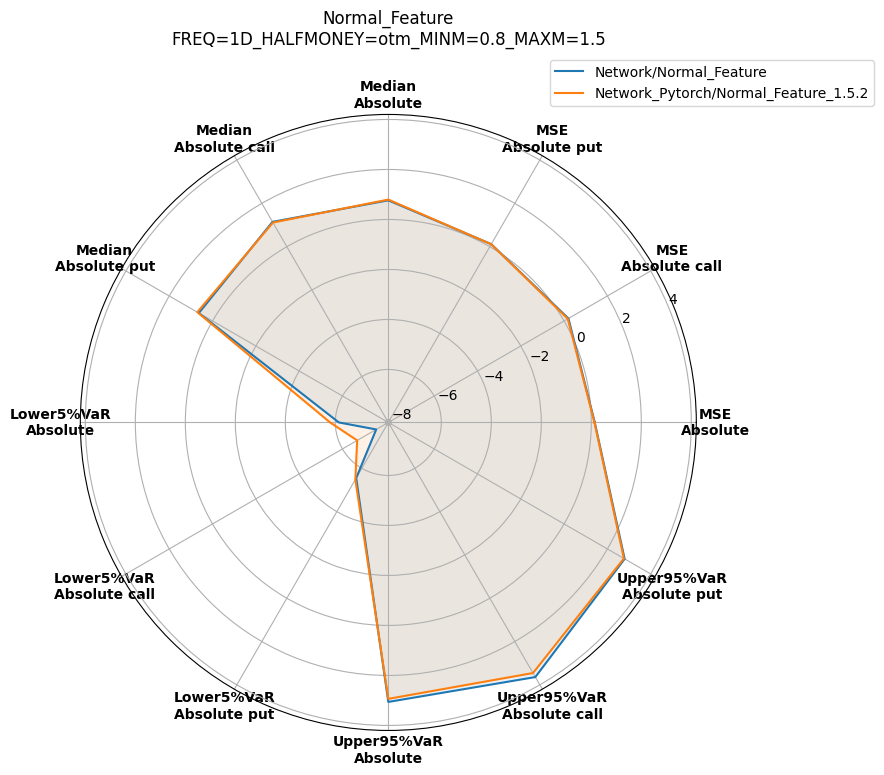

In [25]:
plot_radar(df_radar_normal_feature, filtering="Absolute", lst=["Metric", "Network/Normal_Feature", "Network_Pytorch/Normal_Feature_1.5.2"], title="Normal_Feature\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

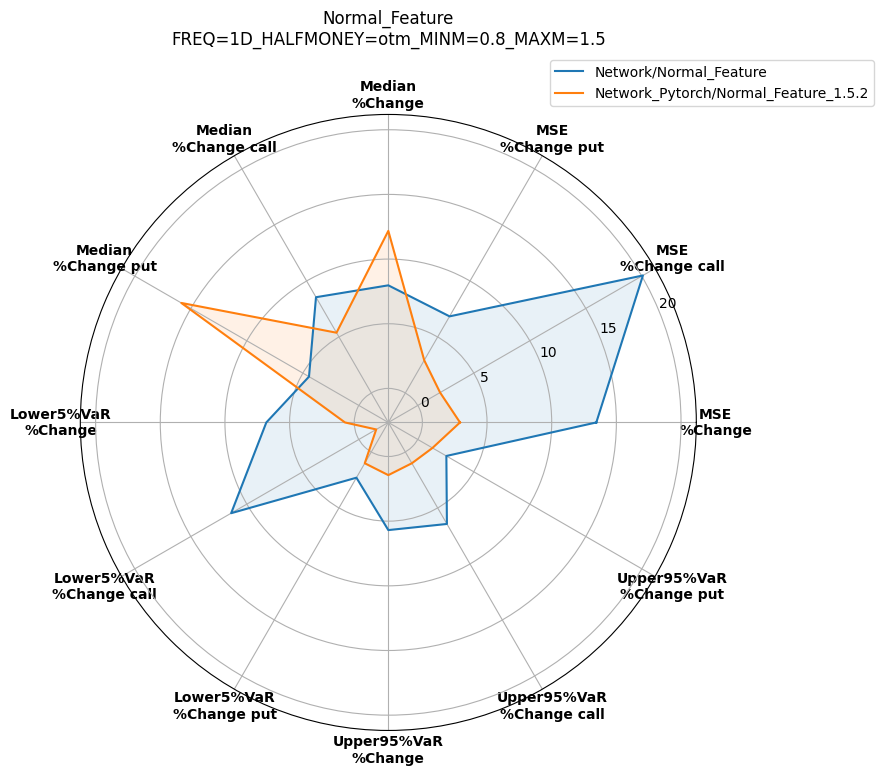

In [26]:
plot_radar(df_radar_normal_feature, filtering="%Change", lst=["Metric", "Network/Normal_Feature", "Network_Pytorch/Normal_Feature_1.5.2"], title="Normal_Feature\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

In [27]:
df_radar_delta_vega = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                   df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                   filtering="Delta_Vega", freq="FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")
df_radar_delta_vega

Metric,Metric,Regression/Delta_Vega_Gamma,Regression/Delta_Vega_Vanna,Regression/Delta_Vega_Gamma_Vanna,Network/Delta_Vega_Vanna,Network_Pytorch/Delta_Vega_Vanna_1.0.0,Network_Pytorch/Delta_Vega_Vanna_1.0.4,Network_Pytorch/Delta_Vega_Vanna_1.5.1,Network_Pytorch/Delta_Vega_Vanna_1.5.2,Network_Pytorch/Delta_Vega_Vanna_1.4.4,Network_Pytorch/Delta_Vega_Vanna_2.5.2,Network/Delta_Vega,Network_Pytorch/Delta_Vega_1.4.4,Network_Pytorch/Delta_Vega_1.5.1,Network_Pytorch/Delta_Vega_2.5.2
0,MSE\nAbsolute,0.123,0.123,0.123,0.126,0.164,0.141,0.137,0.132,0.14,NaN,0.125,0.154,0.134,NaN
1,MSE\n%Change,0.85,0.78,0.9,2.89,34.450001,15.75,11.89,8.1,14.7,NaN,2.13,26.42,9.78,NaN
2,MSE\nAbsolute call,0.165,0.165,0.165,0.171,0.242,0.192,0.186,0.178,0.192,NaN,0.169,0.201,0.182,NaN
3,MSE\n%Change call,-0.73,-0.86,-0.63,2.7,45.689999,15.58,11.86,6.86,15.21,NaN,1.6,20.950001,9.3,NaN
4,MSE\nAbsolute put,0.111,0.11,0.111,0.111,0.114,0.114,0.116,0.116,0.117,NaN,0.111,0.131,0.114,NaN
5,MSE\n%Change put,2.15,2.05,2.16,2.64,5.11,5.41,7.54,6.88,7.7,NaN,2.2,21.280001,5.25,NaN
6,Median\nAbsolute,0.717,0.72,0.716,0.897,0.842,0.875,0.773,0.868,0.779,NaN,0.845,1.118,0.778,NaN
7,Median\n%Change,1.05,1.45,0.93,26.4,18.6,23.23,8.91,22.27,9.79,NaN,19.08,57.459999,9.64,NaN
8,Median\nAbsolute call,1.077,1.081,1.073,1.133,1.193,1.165,1.244,1.132,1.251,NaN,1.124,1.226,1.234,NaN
9,Median\n%Change call,1.98,2.34,1.62,7.25,12.96,10.33,17.83,7.17,18.440001,NaN,6.43,16.08,16.889999,NaN


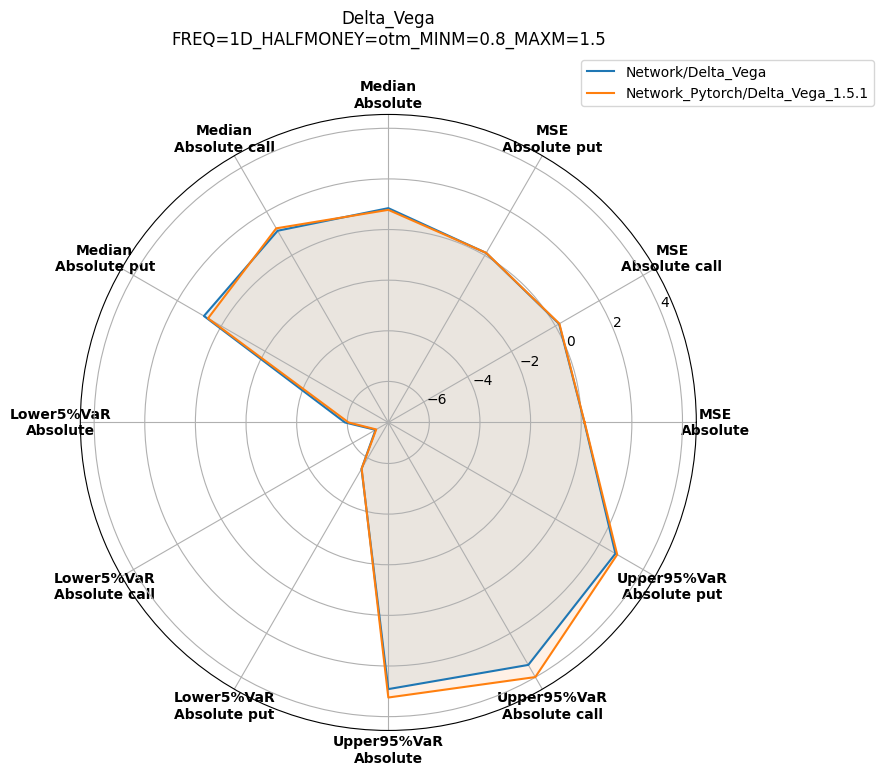

In [28]:
plot_radar(df_radar_delta_vega, filtering="Absolute", lst=["Metric", "Network/Delta_Vega", "Network_Pytorch/Delta_Vega_1.5.1"], title="Delta_Vega\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

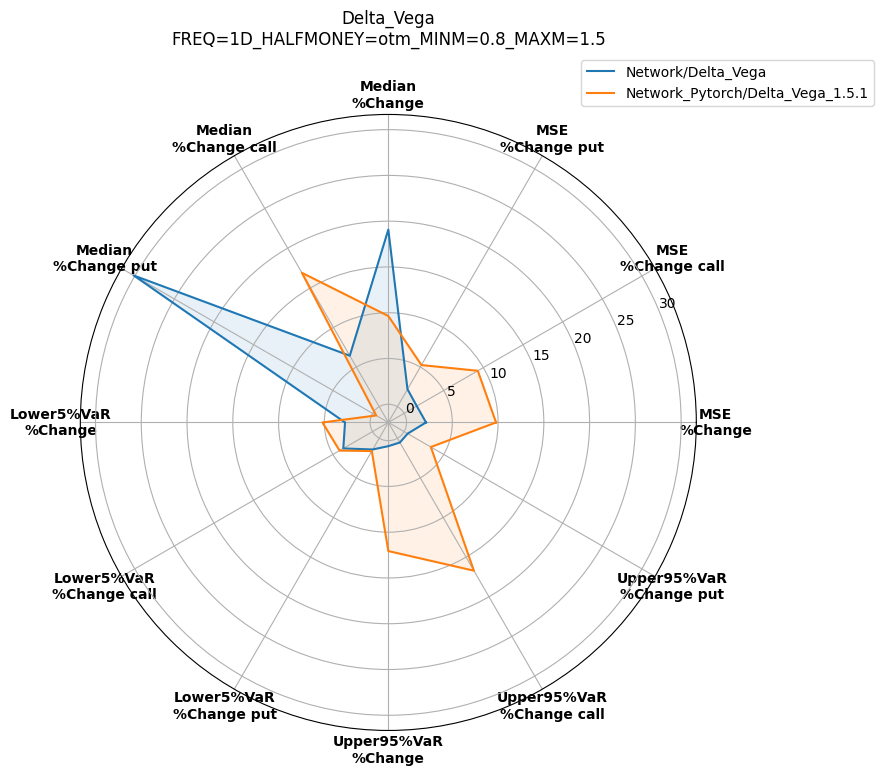

In [29]:
plot_radar(df_radar_delta_vega, filtering="%Change", lst=["Metric", "Network/Delta_Vega", "Network_Pytorch/Delta_Vega_1.5.1"], title="Delta_Vega\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

In [30]:
df_radar_delta_vega_vanna = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                         df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                         filtering="Delta_Vega_Vanna", freq="FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")
df_radar_delta_vega_vanna

Metric,Metric,Regression/Delta_Vega_Vanna,Network/Delta_Vega_Vanna,Network_Pytorch/Delta_Vega_Vanna_1.0.0,Network_Pytorch/Delta_Vega_Vanna_1.0.4,Network_Pytorch/Delta_Vega_Vanna_1.5.1,Network_Pytorch/Delta_Vega_Vanna_1.5.2,Network_Pytorch/Delta_Vega_Vanna_1.4.4,Network_Pytorch/Delta_Vega_Vanna_2.5.2
0,MSE\nAbsolute,0.123,0.126,0.164,0.141,0.137,0.132,0.14,NaN
1,MSE\n%Change,0.78,2.89,34.450001,15.75,11.89,8.1,14.7,NaN
2,MSE\nAbsolute call,0.165,0.171,0.242,0.192,0.186,0.178,0.192,NaN
3,MSE\n%Change call,-0.86,2.7,45.689999,15.58,11.86,6.86,15.21,NaN
4,MSE\nAbsolute put,0.11,0.111,0.114,0.114,0.116,0.116,0.117,NaN
5,MSE\n%Change put,2.05,2.64,5.11,5.41,7.54,6.88,7.7,NaN
6,Median\nAbsolute,0.72,0.897,0.842,0.875,0.773,0.868,0.779,NaN
7,Median\n%Change,1.45,26.4,18.6,23.23,8.91,22.27,9.79,NaN
8,Median\nAbsolute call,1.081,1.133,1.193,1.165,1.244,1.132,1.251,NaN
9,Median\n%Change call,2.34,7.25,12.96,10.33,17.83,7.17,18.440001,NaN


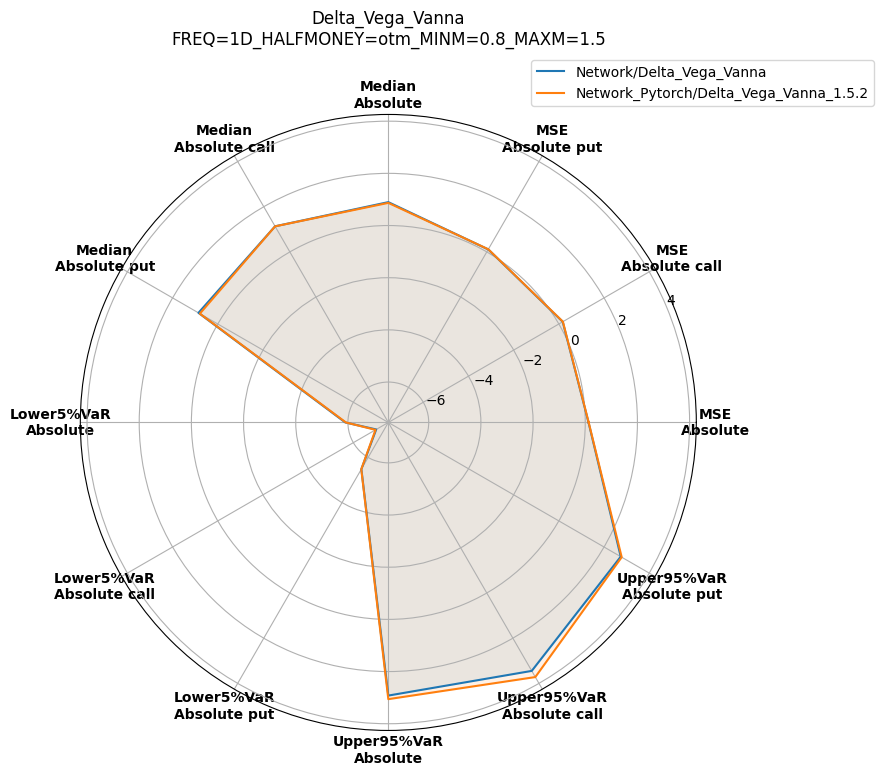

In [31]:
plot_radar(df_radar_delta_vega_vanna, filtering="Absolute", lst=["Metric", "Network/Delta_Vega_Vanna", "Network_Pytorch/Delta_Vega_Vanna_1.5.2"], title="Delta_Vega_Vanna\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

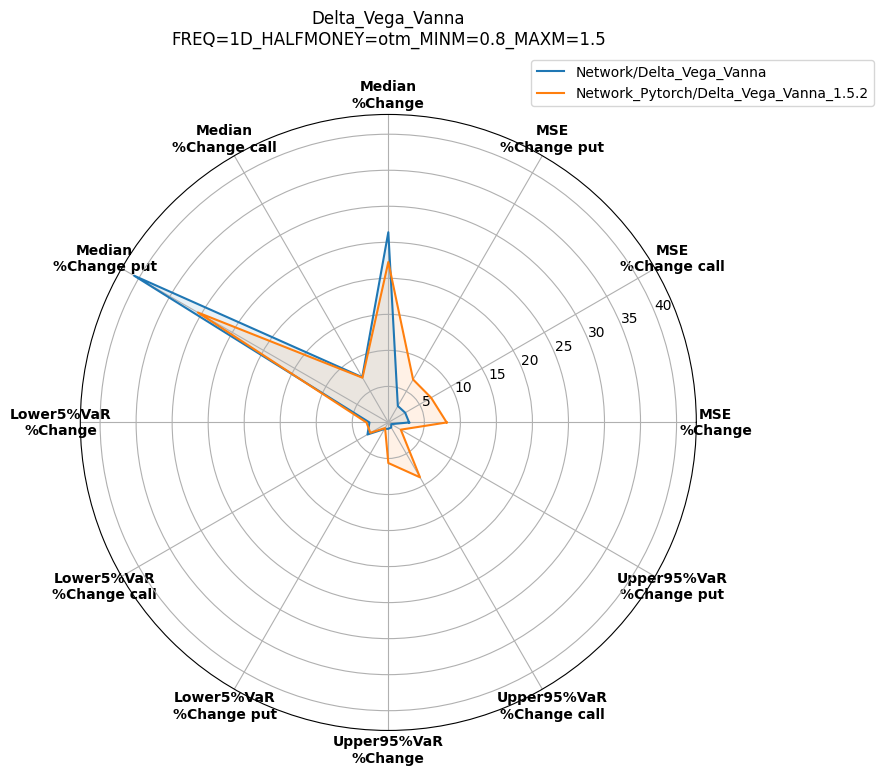

In [32]:
plot_radar(df_radar_delta_vega_vanna, filtering="%Change", lst=["Metric", "Network/Delta_Vega_Vanna", "Network_Pytorch/Delta_Vega_Vanna_1.5.2"], title="Delta_Vega_Vanna\nFREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

## 2D

In [33]:
df_radar_normal_feature = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                         df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                         filtering="Normal_Feature", freq="FREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

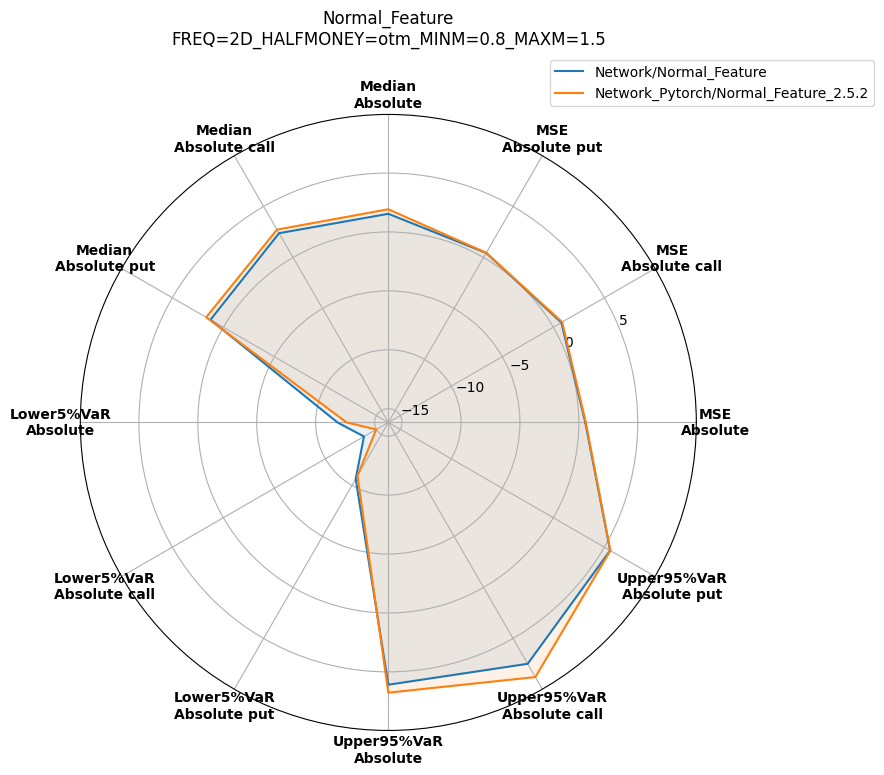

In [34]:
plot_radar(df_radar_normal_feature, filtering="Absolute", lst=["Metric", "Network/Normal_Feature", "Network_Pytorch/Normal_Feature_2.5.2"], title="Normal_Feature\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

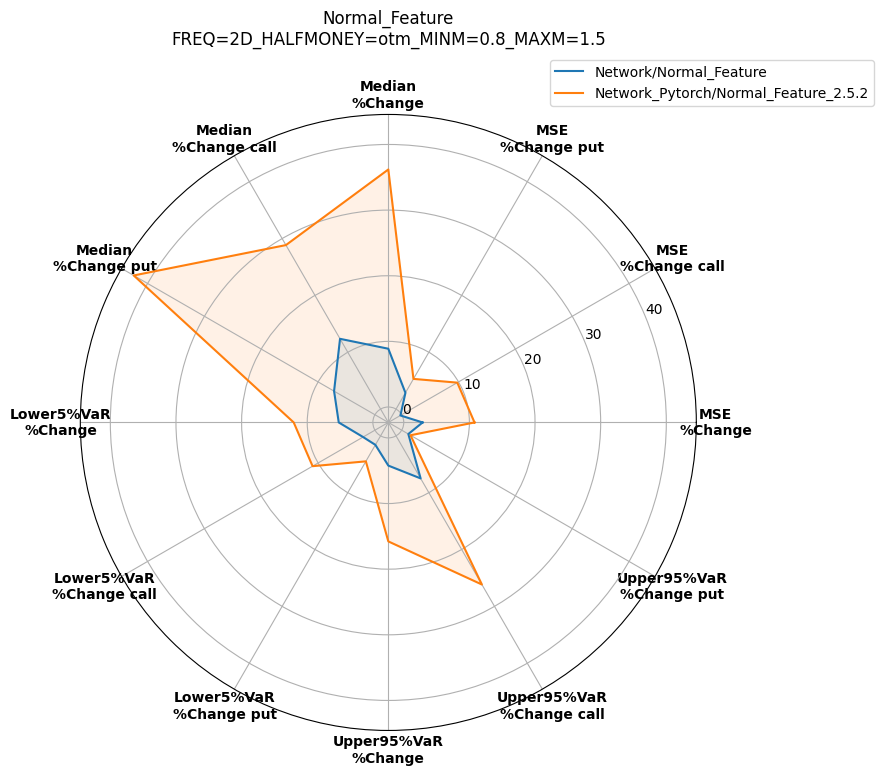

In [35]:
plot_radar(df_radar_normal_feature, filtering="%Change", lst=["Metric", "Network/Normal_Feature", "Network_Pytorch/Normal_Feature_2.5.2"], title="Normal_Feature\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

In [36]:
df_radar_delta_vega = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                   df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                   filtering="Delta_Vega", freq="FREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

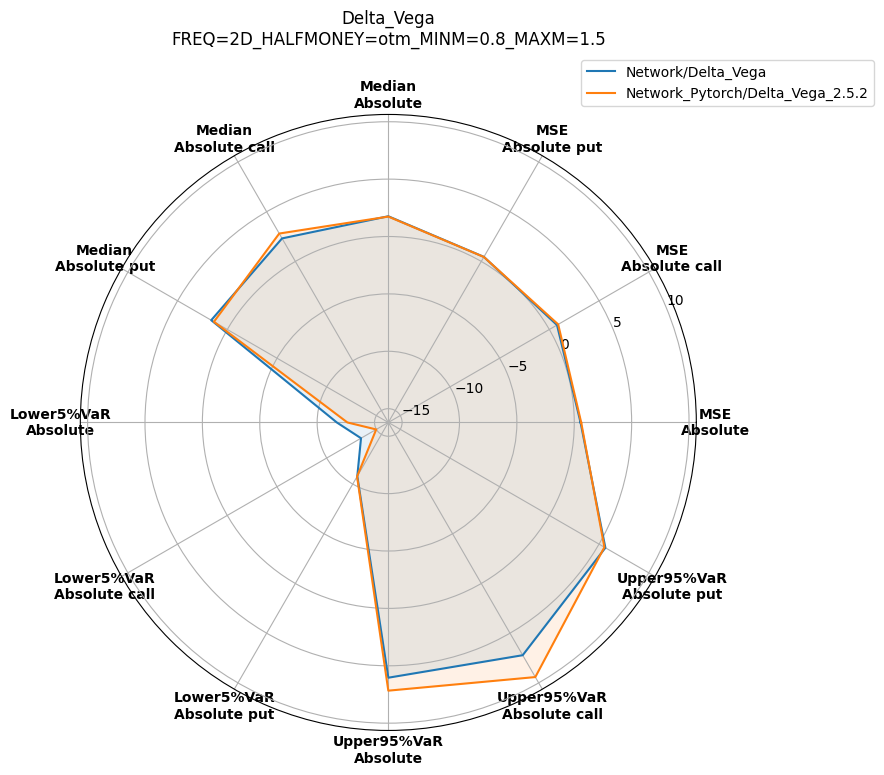

In [37]:
plot_radar(df_radar_delta_vega, filtering="Absolute", lst=["Metric", "Network/Delta_Vega", "Network_Pytorch/Delta_Vega_2.5.2"], title="Delta_Vega\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

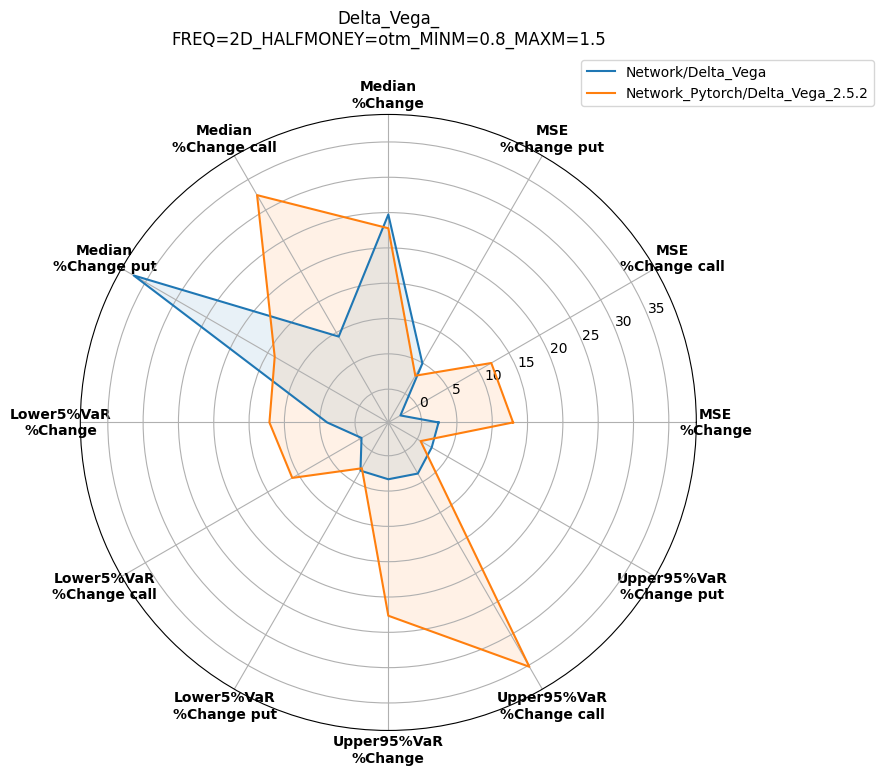

In [38]:
plot_radar(df_radar_delta_vega, filtering="%Change", lst=["Metric", "Network/Delta_Vega", "Network_Pytorch/Delta_Vega_2.5.2"], title="Delta_Vega_\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

In [39]:
df_radar_delta_vega_vanna = pivot_all_df(df_res_mean_mse, df_res_mean_mse_call, df_res_mean_mse_put, df_res_mean_median, df_res_mean_median_call, df_res_mean_median_put,
                                         df_res_mean_lowervar, df_res_mean_lowervar_call, df_res_mean_lowervar_put, df_res_mean_uppervar, df_res_mean_uppervar_call, df_res_mean_uppervar_put, 
                                         filtering="Delta_Vega_Vanna", freq="FREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

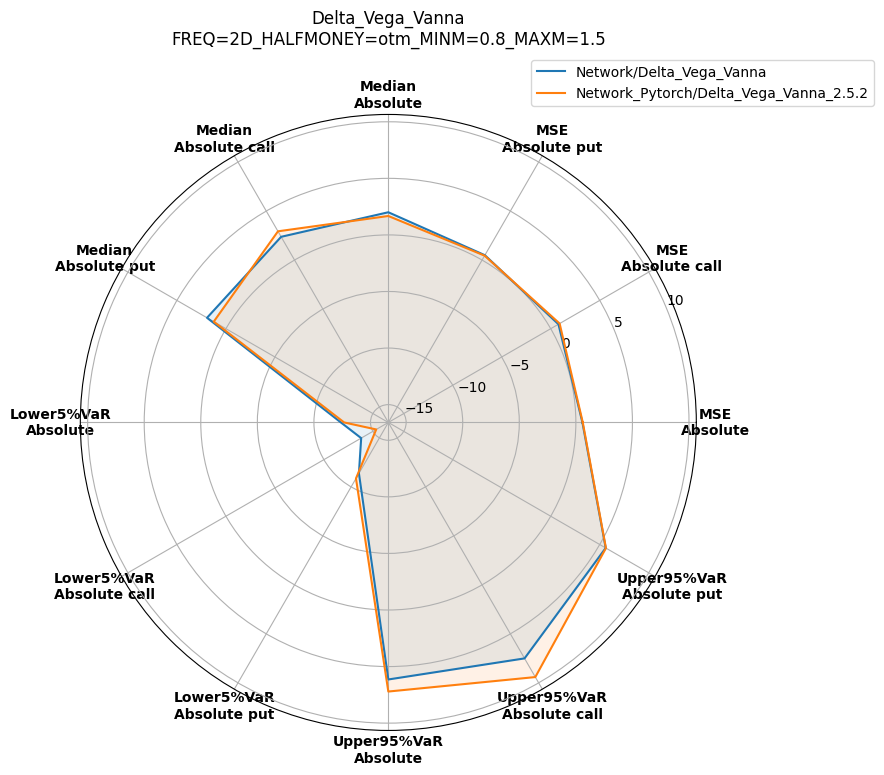

In [40]:
plot_radar(df_radar_delta_vega_vanna, filtering="Absolute", lst=["Metric", "Network/Delta_Vega_Vanna", "Network_Pytorch/Delta_Vega_Vanna_2.5.2"], title="Delta_Vega_Vanna\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")

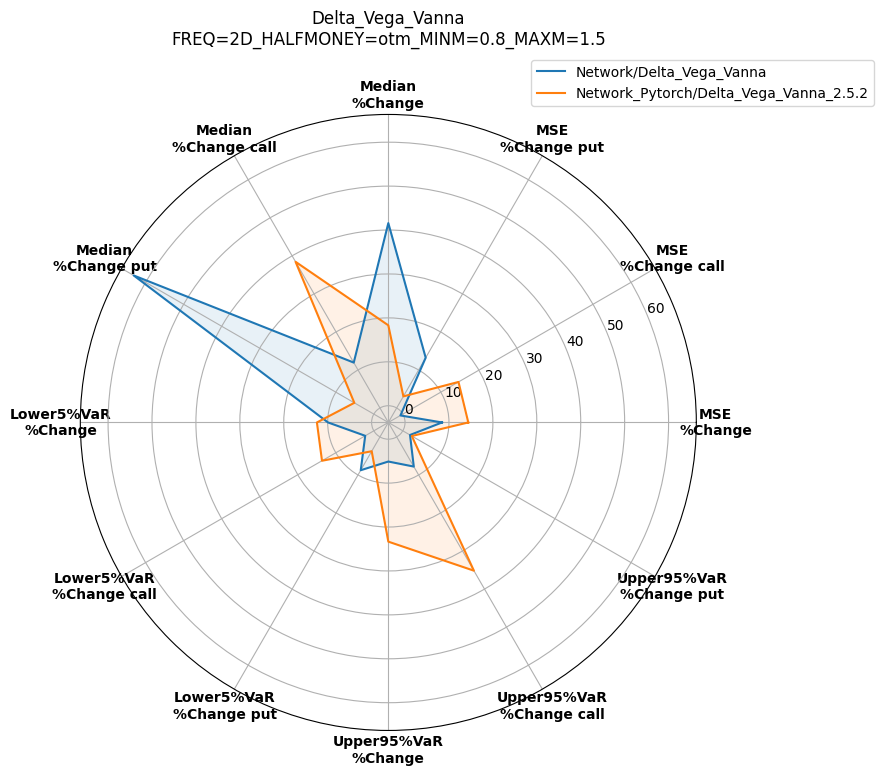

In [41]:
plot_radar(df_radar_delta_vega_vanna, filtering="%Change", lst=["Metric", "Network/Delta_Vega_Vanna", "Network_Pytorch/Delta_Vega_Vanna_2.5.2"], title="Delta_Vega_Vanna\nFREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5")